In [3]:
import numpy as np

def heston_cf(u, tau, r, kappa, theta, sigma, rho, v0, s0):

    x0 = np.log(s0)

    d = np.sqrt((rho*sigma*1j*u - kappa)**2 + sigma**2*(1j*u + u**2))
    g = (kappa - rho*sigma*1j*u - d) / (kappa - rho*sigma*1j*u + d)

    exp_dt = np.exp(-d*tau)

    C = (r*1j*u*tau
         + (kappa*theta/sigma**2) *
           ((kappa - rho*sigma*1j*u - d)*tau
            - 2*np.log((1 - g*exp_dt)/(1 - g))))

    D = ((kappa - rho*sigma*1j*u - d)/sigma**2) * ((1 - exp_dt)/(1 - g*exp_dt))

    return np.exp(C + D*v0 + 1j*u*x0)


In [4]:
def heston_fft_call(
    s0, r, tau,
    kappa, theta, sigma, rho, v0,
    alpha=2,
    N=65536,
    eta=0.01
):

    lam = 2*np.pi/(N*eta)
    b = 0.5 * N * lam

    j = np.arange(N)
    xi = eta * j

    u = xi - (alpha + 1)*1j

    phi = heston_cf(u, tau, r, kappa, theta, sigma, rho, v0, s0)

    numerator = np.exp(-r*tau) * phi
    denominator = alpha**2 + alpha - xi**2 + 1j*(2*alpha + 1)*xi
    psi = numerator / denominator

    weights = np.ones(N)
    weights[0] = 0.5
    weights[1::2] = 4/3
    weights[2::2] = 2/3
    weights *= eta

    fft_input = np.exp(1j*b*xi) * psi * weights

    fft_output = np.fft.fft(fft_input)

    k = -b + lam*j

    calls = np.exp(-alpha*k)/np.pi * np.real(fft_output)

    return k, calls


In [30]:
s0 = 188.85
r = 0.05
tau = 1.0

kappa = 2.0
theta = 0.05
sigma = 0.3
rho = -0.5
v0 = 0.05

In [31]:
k, C = heston_fft_call(
    s0, r, tau,
    kappa, theta, sigma, rho, v0
)

K = 190
price = np.interp(np.log(K), k, C)
print(price)

20.625413904794016


In [1]:
import numpy as np
import matplotlib.pyplot as plt

s0 = 188.85
r = 0.05

kappa = 2.0
theta = 0.05
sigma = 0.3
rho = -0.5
v0 = 0.05

taus = np.linspace(0.1, 2.0, 20)
strikes = np.linspace(0.7*s0, 1.3*s0, 40)

price_surface = np.zeros((len(taus), len(strikes)))


In [5]:
for i, tau in enumerate(taus):
    k_fft, calls_fft = heston_fft_call(
        s0, r, tau,
        kappa, theta, sigma, rho, v0
    )

    K_fft = np.exp(k_fft)

    price_surface[i, :] = np.interp(
        strikes,
        K_fft,
        calls_fft
    )


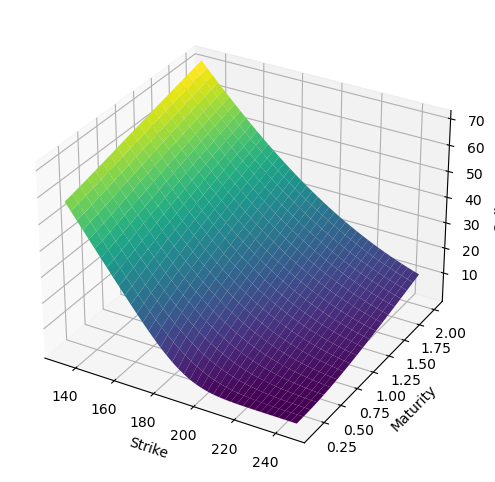

In [6]:
T, K = np.meshgrid(taus, strikes, indexing="ij")

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection="3d")

ax.plot_surface(K, T, price_surface, cmap="viridis")

ax.set_xlabel("Strike")
ax.set_ylabel("Maturity")
ax.set_zlabel("Call Price")

plt.show()
